In [390]:
! pip install plotnine

In [391]:
import pandas as pd
from plotnine import *

### Read and preprocess data

In [392]:
df = pd.read_csv("./data/19_data.csv", sep=";")
df.replace("BÜ90/GR", "BÜNDNIS`90/DIE GRÜNEN", inplace=True)
df.replace("DIE LINKE", "DIE LINKE.", inplace=True)
df.drop("Unnamed: 0", axis=1,inplace=True) # index col
df.head()

,Name,Vorname,Fraktion/Gruppe,19-004-01,19-004-02,19-004-03,19-004-04,19-004-05,19-005-01,19-005-02,...,19-234-02,19-236-01,19-236-02,19-236-03,19-236-04,19-236-05,19-236-06,19-238-01,19-238-02,19-239-01
0,Altmaier,Peter,CDU/CSU,Ja,Ja,Abwesend,Ja,Ja,Ja,Ja,...,Abwesend,Abwesend,Abwesend,Abwesend,Abwesend,Abwesend,Abwesend,Ja,Ja,Abwesend
1,Aumer,Peter,CDU/CSU,Ja,Ja,Ja,Ja,Ja,Ja,Ja,...,Ja,Ja,Ja,Ja,Nein,Ja,Ja,Ja,Ja,Ja
2,Bär,Dorothee,CDU/CSU,Ja,Ja,Ja,Ja,Ja,Ja,Ja,...,Ja,Ja,Ja,Ja,Nein,Ja,Ja,Ja,Ja,Ja
3,Bareiß,Thomas,CDU/CSU,Ja,Ja,Ja,Ja,Ja,Ja,Ja,...,Ja,Ja,Ja,Ja,Nein,Ja,Ja,Ja,Ja,Ja
4,Barthle,Norbert,CDU/CSU,Ja,Ja,Ja,Ja,Ja,Ja,Ja,...,Ja,Ja,Ja,Ja,Nein,Ja,Ja,Ja,Ja,Ja


Remove city information and only use 1st firstname

In [451]:
df["Name"] = df["Name"].map(lambda x: x.split("(")[0])
df["Vorname"] = df["Vorname"].map(lambda x: x.split(" ")[0])
df.shape

(758, 247)

If someone switched fraction, merge values

In [452]:
df = df.groupby(["Name", "Vorname"]).apply(lambda x: x.ffill().bfill()).drop_duplicates(subset=["Name", "Vorname"]).reset_index().drop("index", axis=1)
df.shape

(752, 247)

### Pipeline

allowed values for votes: "Ja" = _yes_, "Nein" = _no_, "Enthaltung" = _abstention_, "Ungültig" = _invalid_, "Abwesend" = _not voted_ or NaN

Columns containing the votes are named with the following scheme: {Period}-{Session}-{Poll}

In [407]:
vote_cols = [c for c in df.columns if "-" in c] 

In [433]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.manifold import TSNE

In [444]:

pipe = Pipeline(
    steps=[
        ('ct', ColumnTransformer(
            transformers=[
                ("preprocess_vote", Pipeline(
                    steps=[
                        ('imputer', SimpleImputer(strategy="constant", fill_value="Abwesend")),
                        ('onehot', OneHotEncoder())
                    ]
                ), vote_cols)
            ],
            sparse_threshold=0)
         ),
         ('tsne', TSNE(init="pca"))
    ]
)
mapping = pipe.fit_transform(df)


In [445]:
df_mapping = pd.DataFrame(mapping, columns=["x", "y"])
df_mapping["name"] = df["Vorname"] + " " + df["Name"]
df_mapping["party"] = df["Fraktion/Gruppe"]
df_mapping.head()

,x,y,name,party
0,9.159902,12.253988,Peter Altmaier,CDU/CSU
1,-15.258219,1.784014,Peter Aumer,CDU/CSU
2,-17.406893,2.639934,Dorothee Bär,CDU/CSU
3,-17.439224,5.380239,Thomas Bareiß,CDU/CSU
4,-17.836061,-0.757794,Norbert Barthle,CDU/CSU


In [ ]:
colors = {
    "AfD": '#009ee0',
    "FDP": '#ffff00',
    "CDU/CSU": '#000000',
    "SPD": '#E3000F',
    "BÜNDNIS`90/DIE GRÜNEN": '#46962b',
    "DIE LINKE.": '#BE3075',
    "Fraktionslos": "#333333"
    }

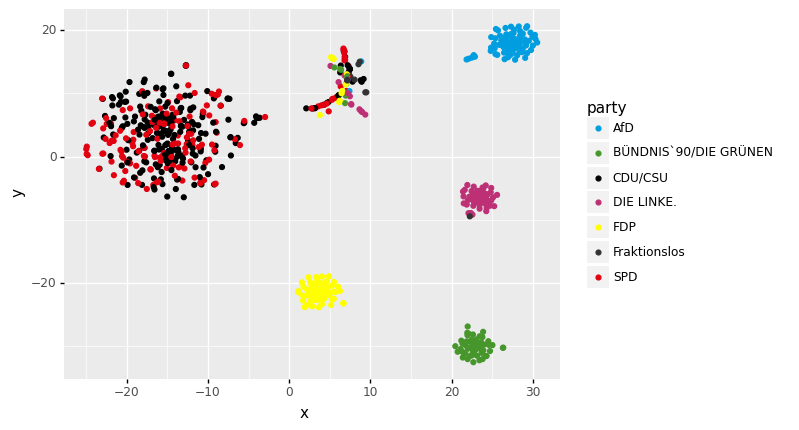

<ggplot: (95385808580)>

In [446]:
ggplot(df_mapping, aes(x="x", y="y", label="name")) + geom_point(aes(colour = "party")) + scale_color_manual(values = colors)